In [2]:
import json
import sys
import warnings
import csv

import torch
import torch.optim as optim
import torch.quantization
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

import config
from loss import YoloLoss
from model import YOLOv3
from utils import (
    cells_to_bboxes,
    check_class_accuracy,
    evaluation_box_class,
    get_evaluation_bboxes,
    get_loaders,
    mean_average_precision,
    plot_couple_examples,
    save_checkpoint,
    size_measure,
    test_latency,
    cells_to_bboxes,
    non_max_suppression
    
)
import albumentations as A
import cv2
import torch
from albumentations.pytorch import ToTensorV2

from utils import seed_everything
from dataset import YOLODataset
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps, ImageGrab
import glob

import config

In [3]:
path = "T:/FYP_dataset/mixed"
test_loader = get_loaders("test", path + "/test4.csv", batch_size=24)

In [5]:
model = YOLOv3(num_classes=config.NUM_CLASSES).to('cuda').eval()
checkpoint = torch.load(config.CHECKPOINT_FILE, map_location='cuda')
model.load_state_dict(checkpoint["state_dict"], strict=False)

scaled_anchors = (
    torch.tensor(config.ANCHORS)
    * torch.tensor(config.S).unsqueeze(1).unsqueeze(1).repeat(1, 3, 2)
).to('cuda')
anchors2 = scaled_anchors

In [6]:
def draw_box(annotations, ax, im):
    cmap = plt.get_cmap("tab20b")
    class_labels = config.CLASSES
    colors = [cmap(i) for i in np.linspace(0, 1, len(class_labels))]
    height, width, _ = im.shape
    for box in annotations:
        assert (
            len(box) == 6
        ), "box should contain class pred, confidence, x, y, width, height. Received: {}".format(box)
        class_pred = box[0]
        conf = box[1]
        box = box[2:]
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=2,
            edgecolor=colors[int(class_pred)],
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(
            upper_left_x * width - 1,
            upper_left_y * height - 10,
            s=f"{class_labels[int(class_pred)]} {conf*100:0.0f}%",
            color="black",
            verticalalignment="top",
            bbox={"color": colors[int(class_pred)], "pad": 0},
        )

In [7]:
def plot_image(image, boxes, true_boxes=None):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image) / 255
    height, width, _ = im.shape
    # Create figure and axes
    fig, ax = plt.subplots(1,2, figsize=(20,10))
    # Display the image
    if not true_boxes:
        ax[0].imshow(im)
        draw_box(boxes, ax[0], im)
    else:
        for axis in ax:
            axis.imshow(im)
        # Predicted boxes
        draw_box(boxes, ax[0], im)
        # True Boxes
        draw_box(true_boxes, ax[1], im)
    plt.show()

In [35]:
def process_image(images, true_labels=None):
    for indx, img in enumerate(images):
        x = np.array(img)
        x = np.moveaxis(x, -1, 0)
        x = torch.from_numpy(x).unsqueeze(0)
        x = x.to("cuda").float()
        with torch.no_grad():
            out = model(x)
        bboxes = [[] for _ in range(x.shape[0])]
        for i in range(3):
            batch_size, A, S, _, _ = out[i].shape
            anchor = anchors2[i]
            boxes_scale_i = cells_to_bboxes(out[i], anchor, S=S, is_preds=True)
            for idx, (box) in enumerate(boxes_scale_i):
                bboxes[idx] += box

        for i in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[i],
                iou_threshold=0.2,
                threshold=0.8,
                box_format="midpoint",
            )
            #remove_small_predictions(nms_boxes)
            plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, true_boxes=true_labels[indx])

In [39]:
with open(config.DATASET + "/test4.csv") as csv_file:
    reader = csv.reader(csv_file, delimiter=',')
    data = list(reader)
images = []
all_annotations = []
for sample in data[:20]:
    image = Image.open(config.DATASET + '/' + sample[0]).convert("RGB")
    #image = ImageOps.grayscale(image)
    images.append(image)
    with open(config.DATASET + '/' + sample[1], "r") as f:
        annotations = f.readlines()
        annotations = [label.replace('\n','').split(" ") for label in annotations]
        for i in range(len(annotations)):
            annotations[i] = [float(a) for a in annotations[i]]
        [a.insert(1, 1.0) for a in annotations]
        #annotations = [[int(a[0])] + a[1:] for a in annotations]
        all_annotations.append(annotations)
# folder = 'C:/fyp/hematology/Data/WBC_20220215/full_image/Purple/tiled'
# img_folder = os.listdir(folder)
# i=10
# images = [ImageOps.pad(Image.open(folder + '/' + img_file).convert("RGB"), size=(512,512)) for img_file in img_folder[:i] if img_file.endswith(".png")]

In [40]:
def remove_small_predictions(bboxes):
    remove_list = []
    for i, bbox in enumerate(bboxes):
        if (bbox[4]*bbox[5] < 0.005):
            remove_list.append(i)
    for i in sorted(remove_list, reverse=True):
        del bboxes[i]

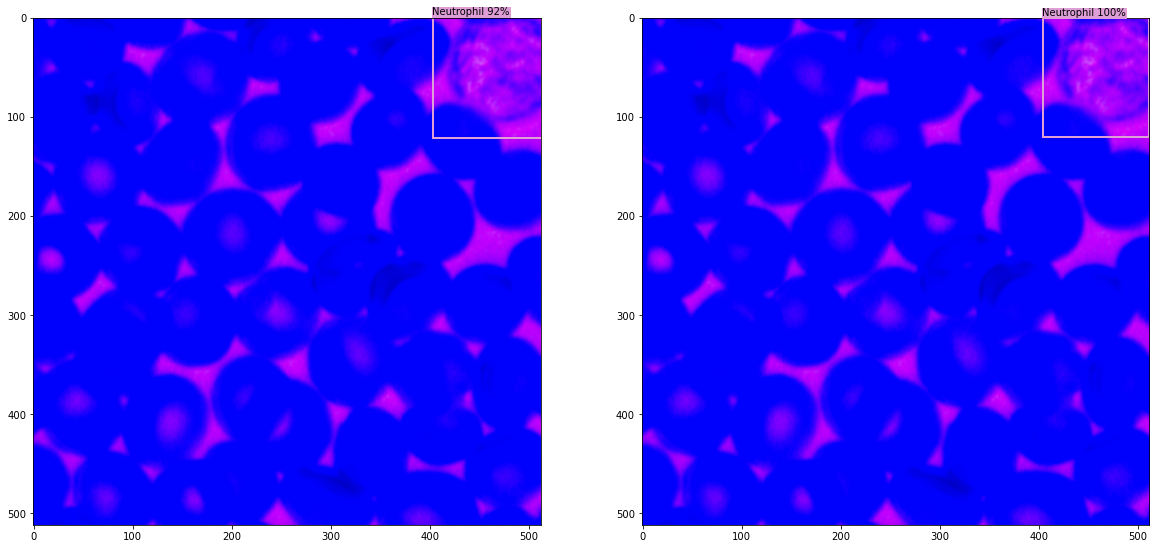

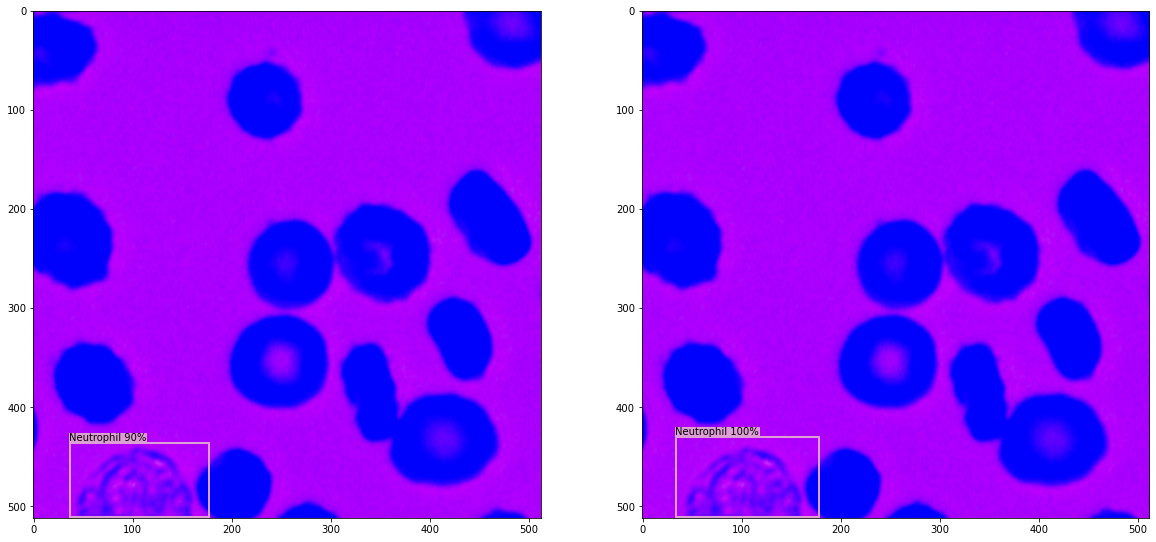

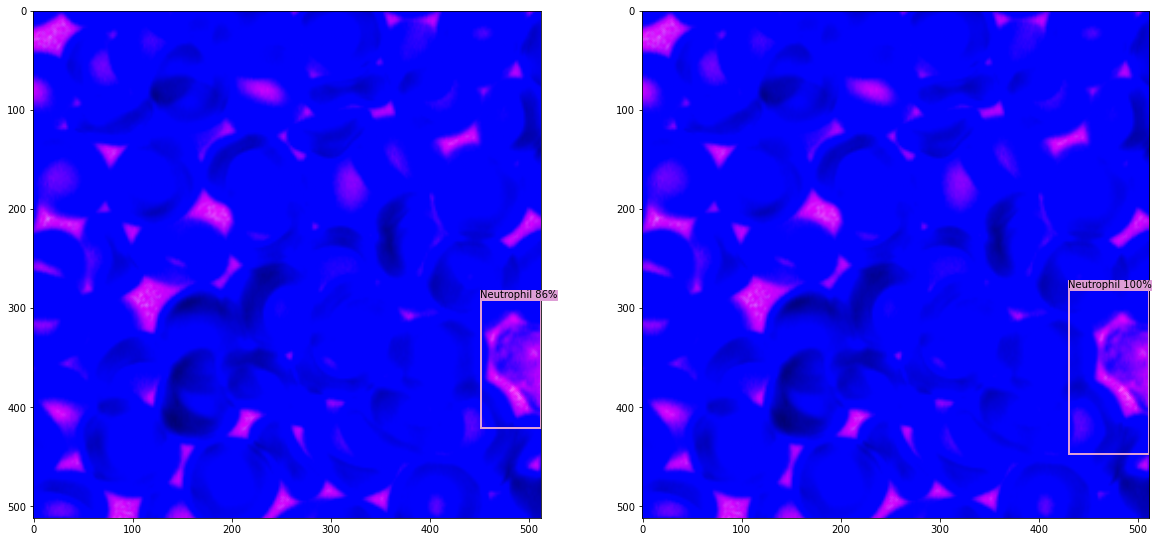

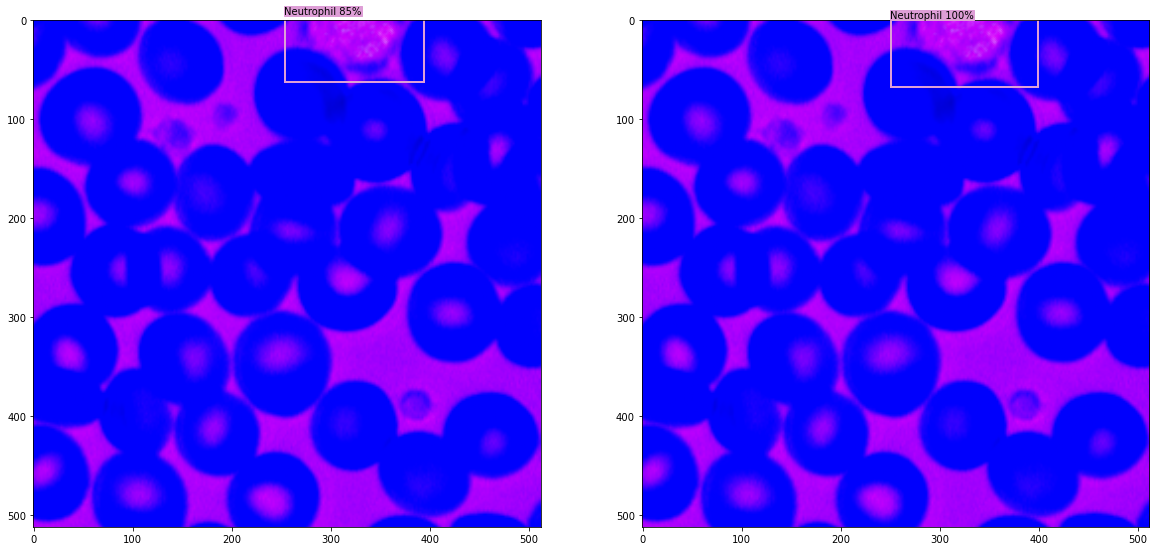

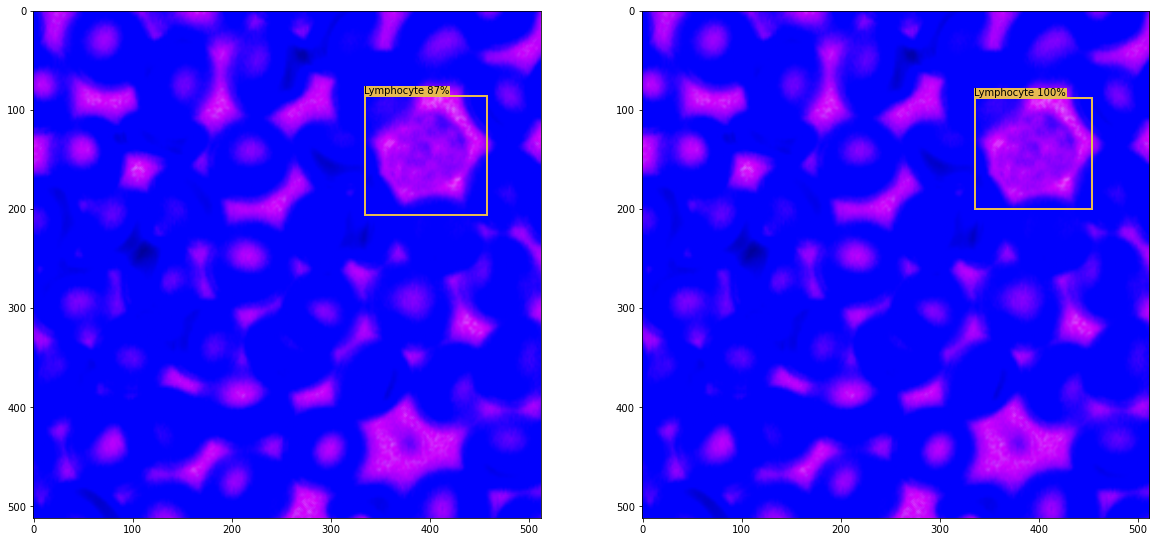

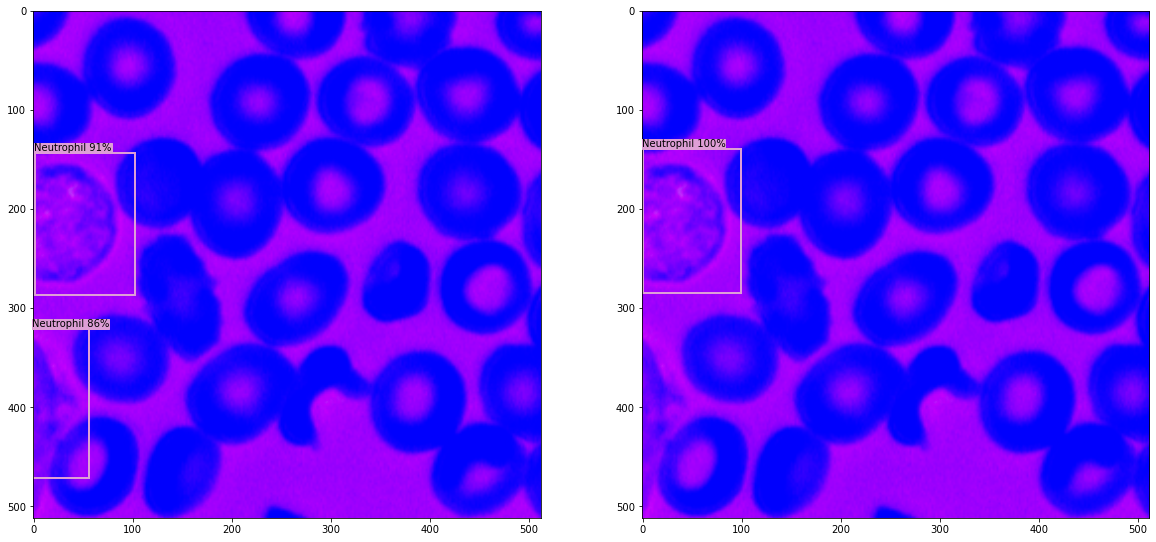

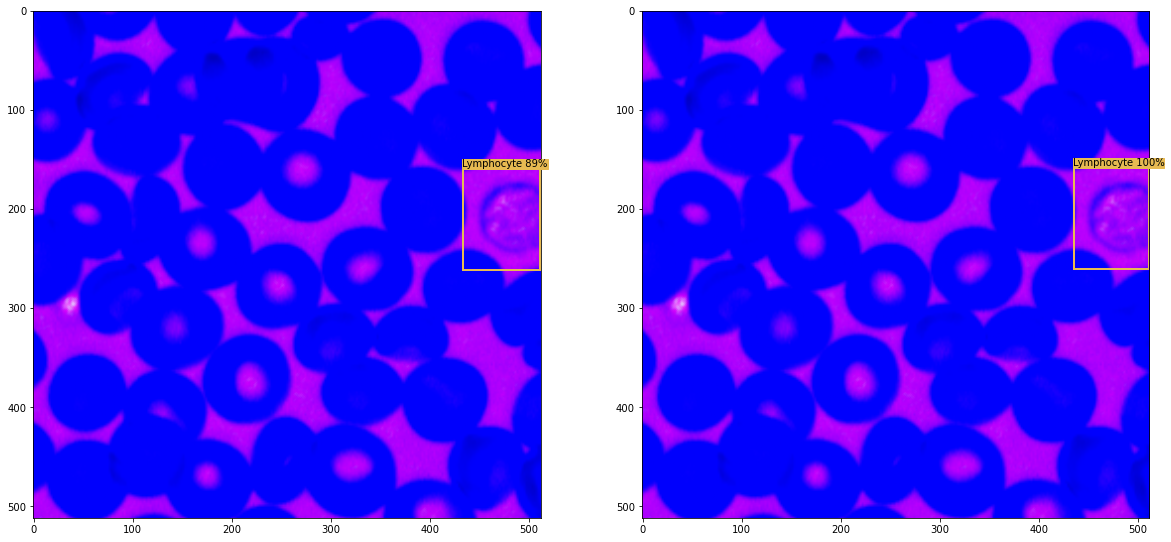

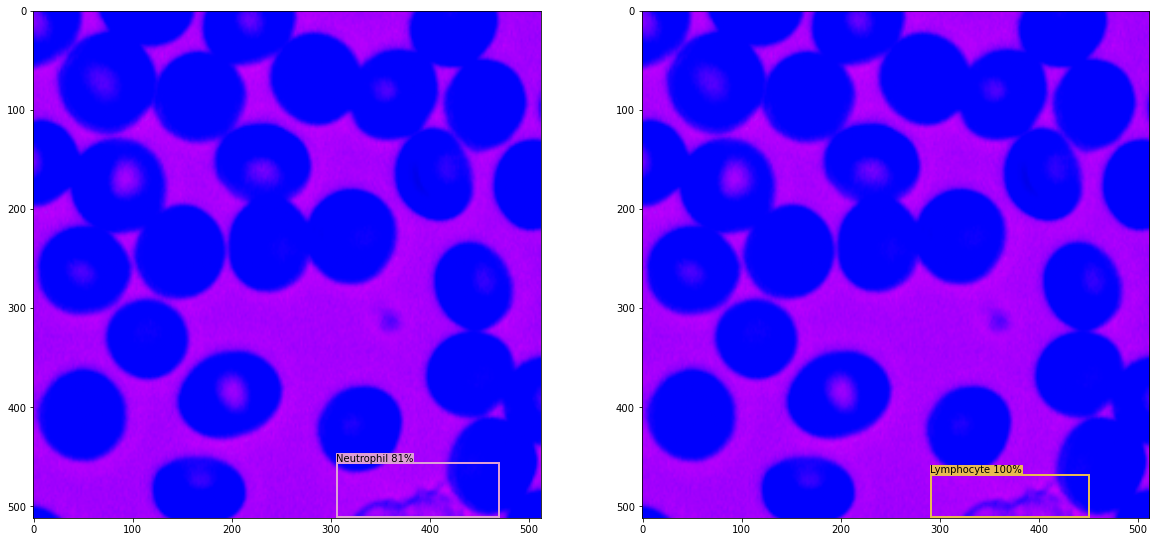

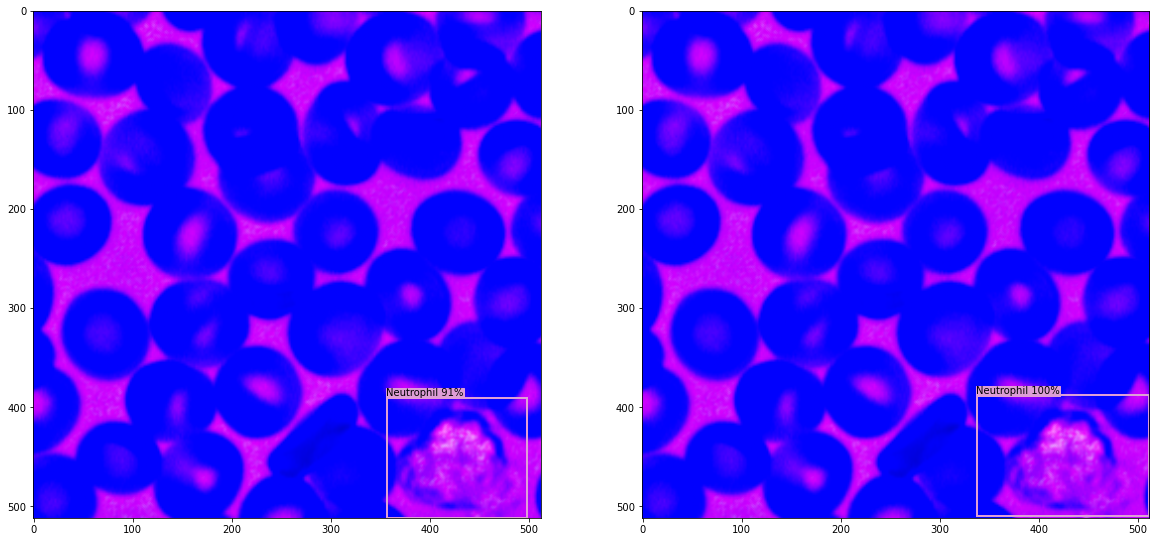

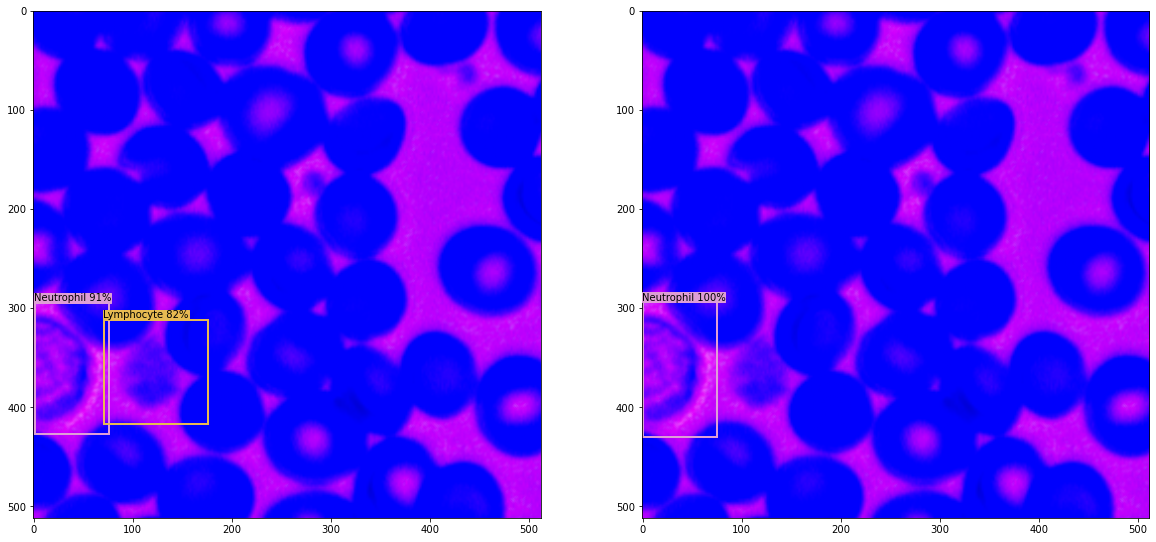

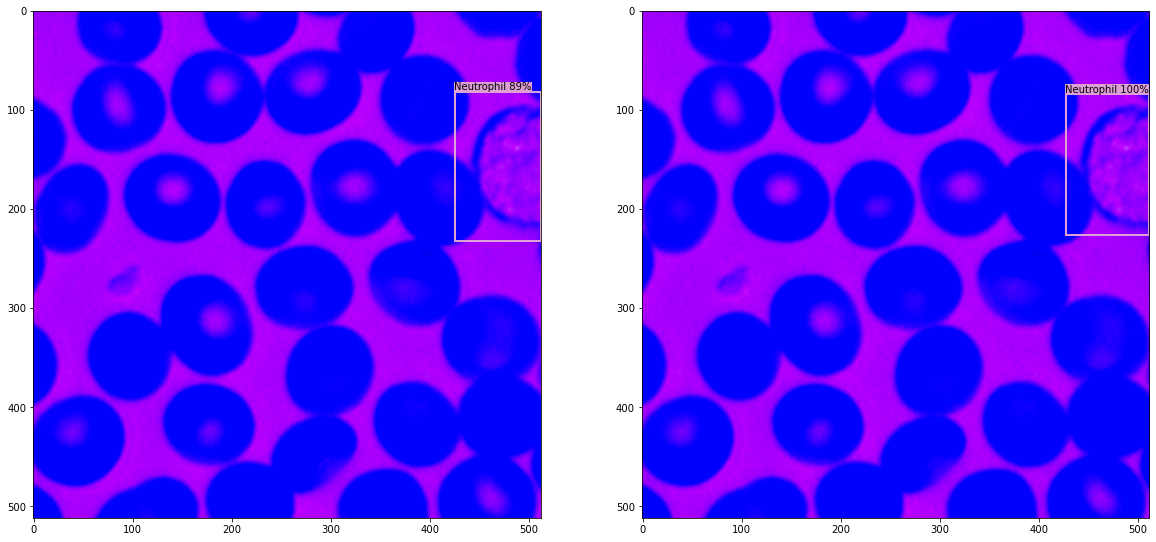

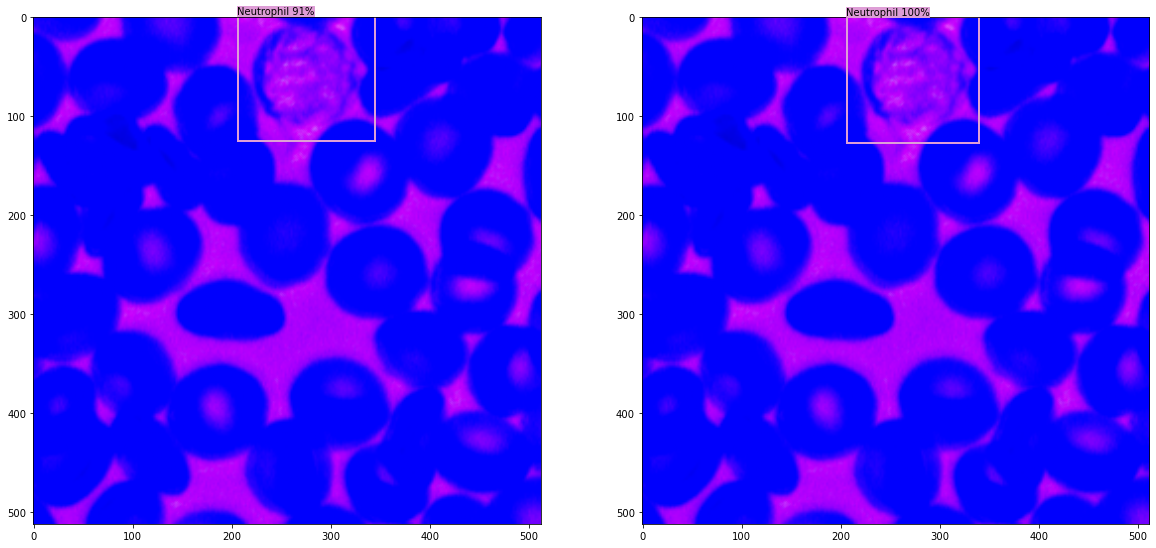

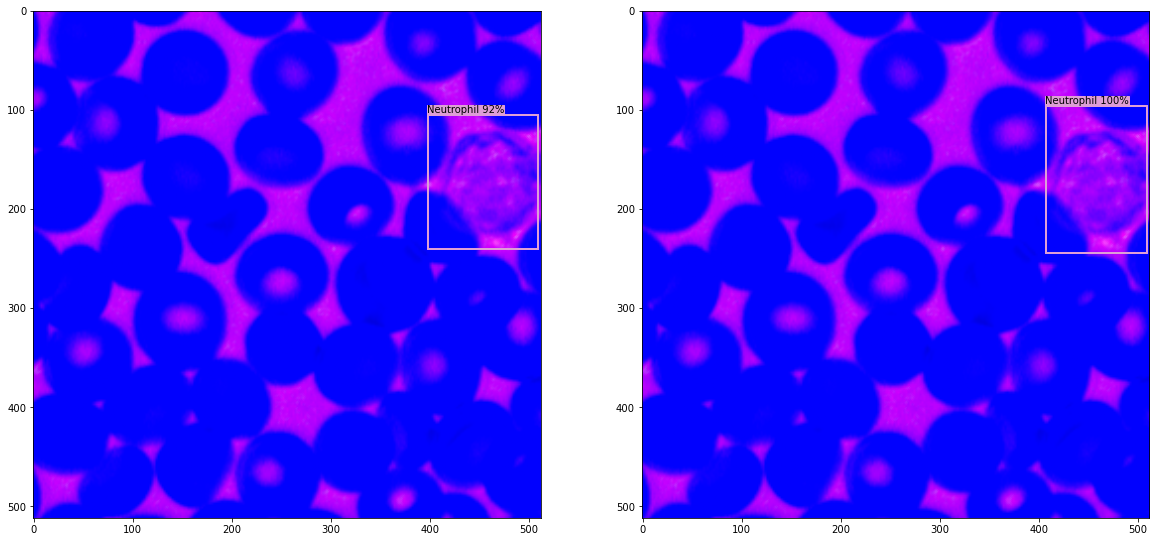

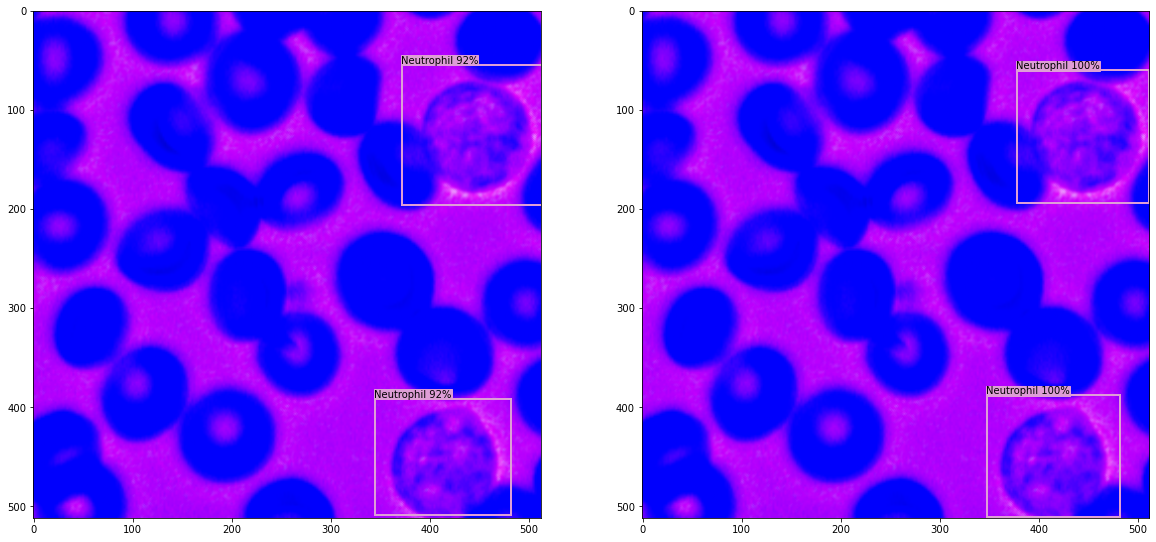

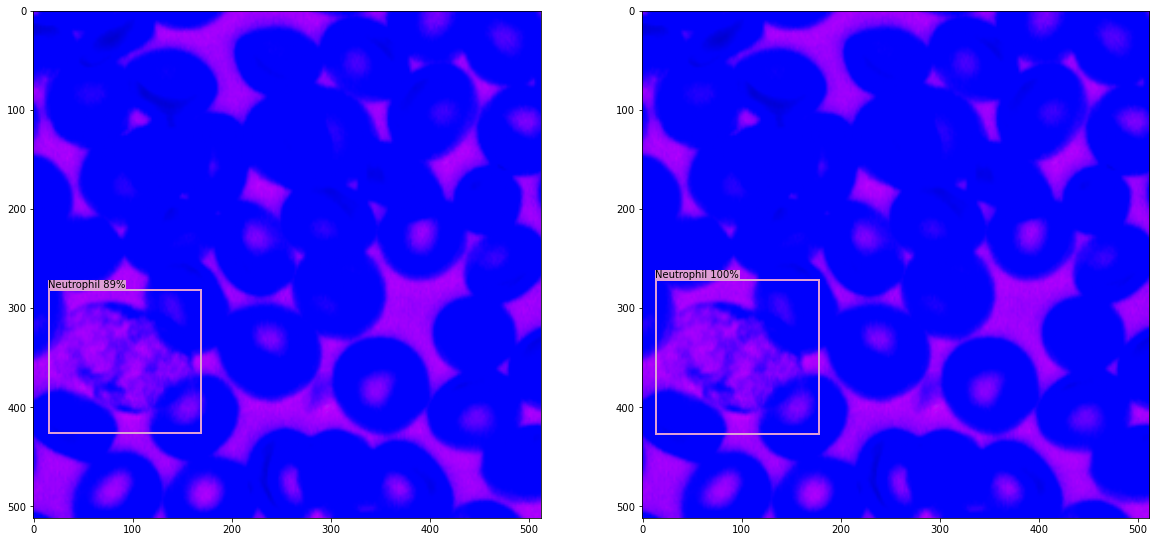

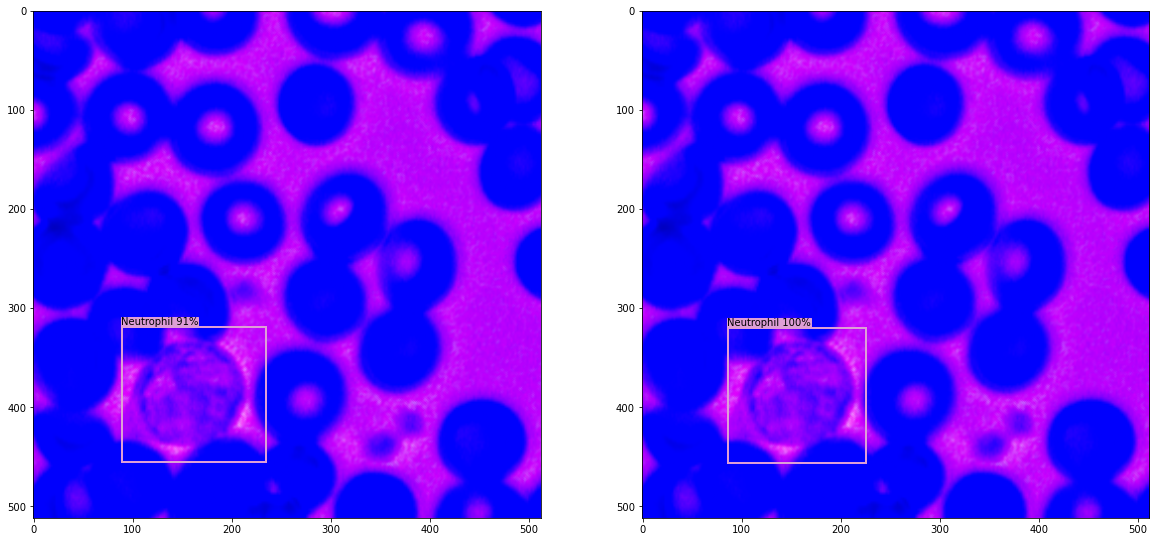

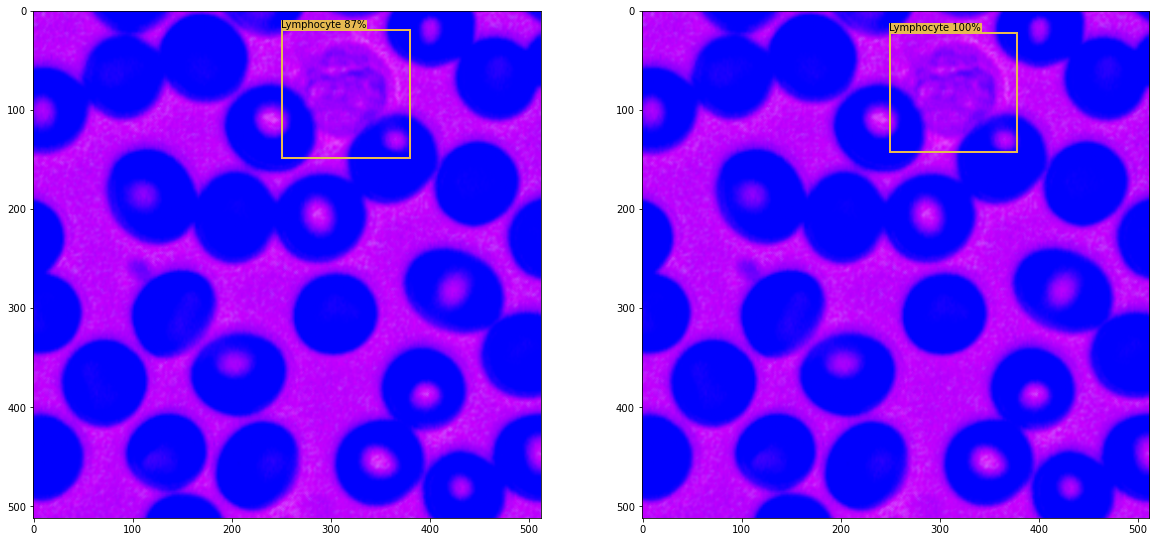

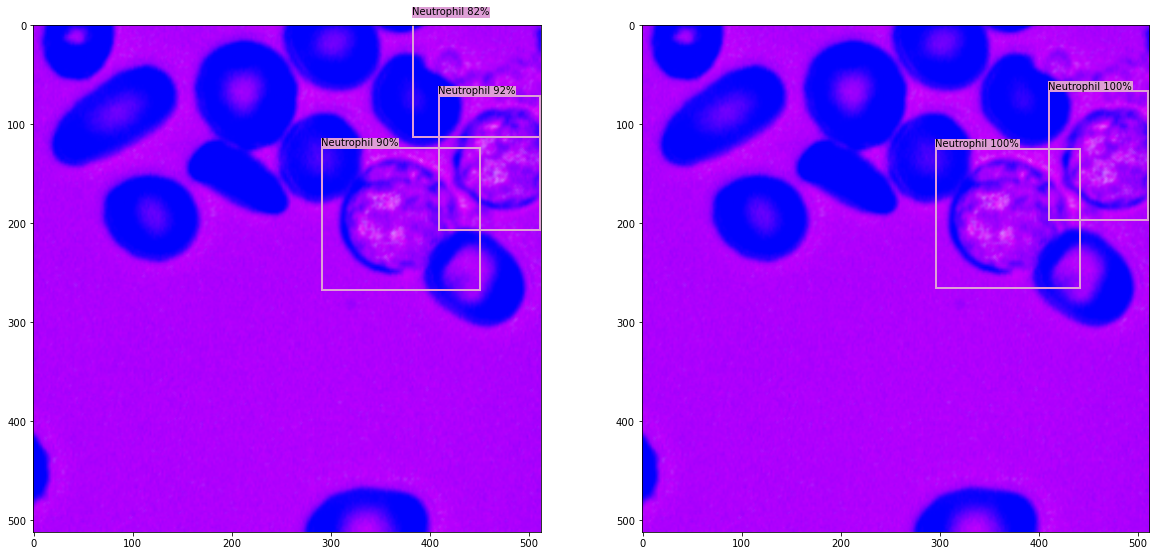

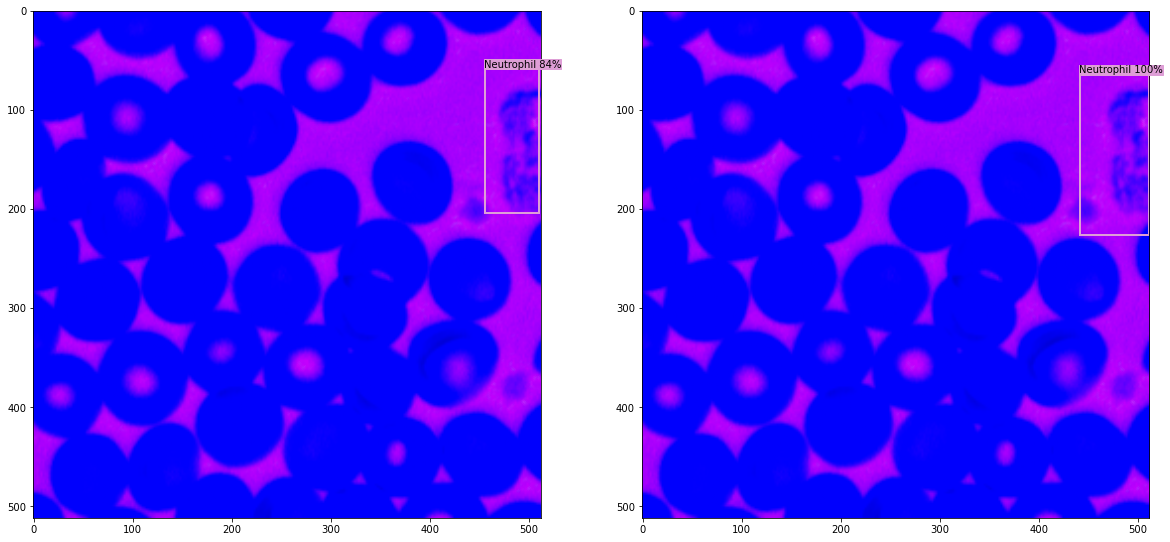

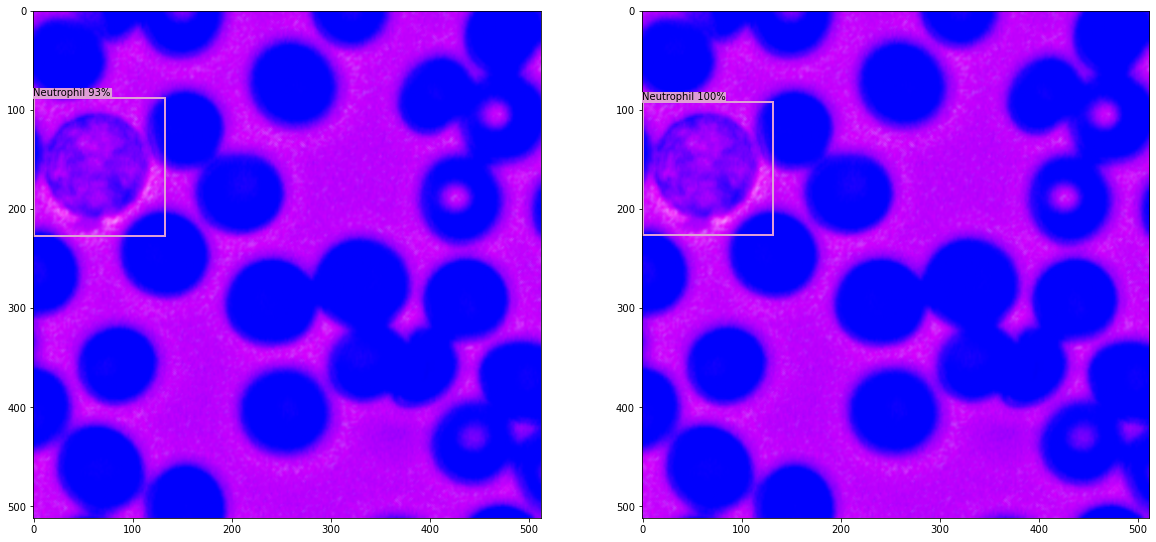

In [41]:
process_image(images, true_labels=all_annotations)

# ONNX Conversion and Runtime

In [43]:
model.to('cpu')
dummy_input = torch.randn(1,3,512,512)
input_names = ["actual_input"]
output_names = ['output1','output2','output3']

In [45]:
torch.onnx.export(model, dummy_input, "yolov3_onnx.onnx", opset_version=11, verbose=False, input_names=input_names, output_names=output_names, export_params=True)

In [115]:
import onnxruntime as onnxrt

x = np.array(images[0]).astype(np.float32)
x = np.moveaxis(x, -1, 0)
x = np.expand_dims(x, axis=0)
onnx_session = onnxrt.InferenceSession("yolov3_onnx.onnx", providers=["CUDAExecutionProvider"])
onnx_inputs = {onnx_session.get_inputs()[0].name: x}
out = onnx_session.run(None, onnx_inputs)

In [116]:
print(out[0].shape)
print(out[1].shape)
print(out[2].shape)

(1, 3, 16, 16, 10)
(1, 3, 32, 32, 10)
(1, 3, 64, 64, 10)


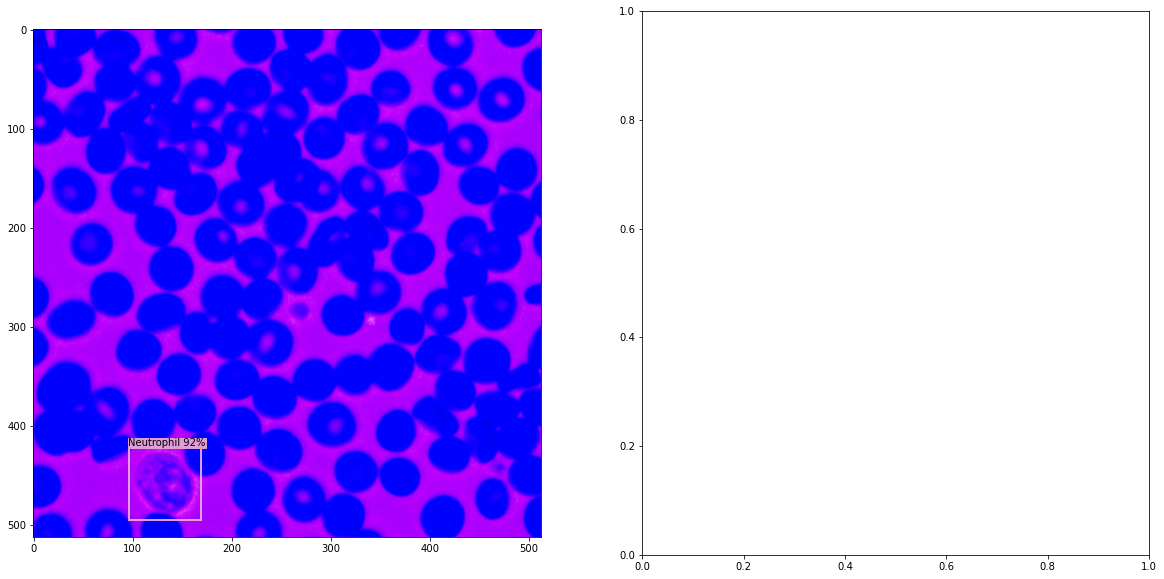

In [117]:
bboxes = [[] for _ in range(x.shape[0])]
# Convert list of np_arrays to tensors
out = [torch.from_numpy(a).to('cuda') for a in out]
for i in range(3):
    batch_size, A, S, _, _ = out[i].shape
    anchor = anchors2[i]
    boxes_scale_i = cells_to_bboxes(out[i], anchor, S=S, is_preds=True)
    for idx, (box) in enumerate(boxes_scale_i):
        bboxes[idx] += box
for i in range(batch_size):
    nms_boxes = non_max_suppression(
        bboxes[i],
        iou_threshold=iou_thresh,
        threshold=0.7,
        box_format="midpoint",
    )
    remove_small_predictions(nms_boxes)
    x = torch.from_numpy(x)
    plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, true_boxes=False)